# Convert RAW files to MGF

Filters:

- Vendor peak picking
- Recalculate precursor m/z and charge

In [ ]:
! ../bin/msconvert --outdir ../data/interim --mgf --filter "peakPicking vendor msLevel=2" --filter "msLevel 2" --filter "precursorRecalculation" ../data/raw/*.raw

# MaRaCluster clustering

Generate MaRaCluster clusters and create corresponding consensus spectra.

In [ ]:
! mkdir ../data/processed/20180427_lpino_qehf2_ypic_trypsin_maracluster
! ls -1 ../data/interim/*.mgf > ../data/processed/20180427_lpino_qehf2_ypic_trypsin_maracluster/files.txt

In [ ]:
! ../bin/maracluster batch -b ../data/processed/20180427_lpino_qehf2_ypic_trypsin_maracluster/files.txt -f ../data/processed/20180427_lpino_qehf2_ypic_trypsin_maracluster -c -5.0 -p 50ppm -C 1 -t -5.0 -M 3

In [ ]:
! ../bin/maracluster consensus -l ../data/processed/20180427_lpino_qehf2_ypic_trypsin_maracluster/MaRaCluster.clusters_p5.ms2 -f ../data/processed/20180427_lpino_qehf2_ypic_trypsin_maracluster -o MaRaCluster.consensus_p5.ms2
! mv ../data/processed/20180427_lpino_qehf2_ypic_trypsin_maracluster/MaRaCluster.consensus_p5_part1.ms2 ../data/processed/20180427_lpino_qehf2_ypic_trypsin_maracluster/MaRaCluster.consensus_p5.ms2

In [ ]:
! ../bin/msconvert --mgf --outdir ../data/processed/20180427_lpino_qehf2_ypic_trypsin_maracluster ../data/processed/20180427_lpino_qehf2_ypic_trypsin_maracluster/MaRaCluster.consensus_p5.ms2

### General Python stuff

In [1]:
import collections
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from pyteomics import mgf
from spectrum_utils import spectrum

import spectral_network

In [2]:
# Plot styling.
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')

# Clustering filtering

In [3]:
min_num_spectra_per_cluster = 10

Only retain high-quality spectral clusters:

- Consensus clusters with precursor charge 2+ or 3+.
- At least {{min_num_spectra_per_cluster}} spectra per cluster.

In [4]:
dir_maracluster = '../data/processed/20180427_lpino_qehf2_ypic_trypsin_maracluster'
postfix = 'p5'

In [5]:
# Read the consensus spectra.
spectra = []
with mgf.read(os.path.join(
        dir_maracluster, f'MaRaCluster.consensus_{postfix}.mgf')) as f_in:
    for spec in f_in:
        spectra.append(spectrum.MsmsSpectrum(
            identifier=spec['params']['title'],
            precursor_mz=spec['params']['pepmass'][0],
            precursor_charge=spec['params']['charge'][0],
            mz=spec['m/z array'],
            intensity=spec['intensity array'],
            retention_time=spec['params']['rtinseconds']))

In [6]:
# Add for each consensus spectrum references to its original spectra.
clusters = []
with open(os.path.join(
        dir_maracluster, f'MaRaCluster.clusters_{postfix}.tsv')) as f_in:
    current_cluster = []
    for line in f_in:
        if not line.strip():
            clusters.append(current_cluster)
            current_cluster = []
        else:
            mgf_filename = line.split()[0]
            scan_nr = int(line.split()[1])
            current_cluster.append((mgf_filename, scan_nr))
for spec, cluster in zip(spectra, clusters):
    spec.cluster = cluster

In [7]:
# Only keep consensus spectra with charge 2+ and 3+.
spectra = [spec for spec in spectra
           if spec.precursor_charge in (2, 3)]

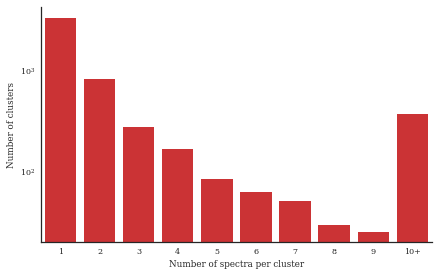

In [8]:
width = 7
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))

max_num_spectra = 10
cluster_spectrum_counts = collections.defaultdict(int)
temp = collections.Counter([len(spec.cluster) for spec in spectra])
for num_spectra in sorted(temp.keys()):
    new_key = str(num_spectra) if num_spectra < max_num_spectra else f'{max_num_spectra}+'        
    cluster_spectrum_counts[new_key] += temp[num_spectra]

sns.barplot(x=list(cluster_spectrum_counts.keys()),
            y=list(cluster_spectrum_counts.values()),
            color='#e41a1c', ax=ax)

ax.set_yscale('log')

ax.set_xlabel('Number of spectra per cluster')
ax.set_ylabel('Number of clusters')

sns.despine(ax=ax)

# plt.savefig('cluster_sizes.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [9]:
spectra_filtered = [spec for spec in spectra
                    if len(spec.cluster) >= min_num_spectra_per_cluster]
print(f'{len(spectra_filtered)} consensus spectra retained after filtering')

380 consensus spectra retained after filtering


In [10]:
# Write the filtered consensus spectra to a new MGF file.
with mgf.read(os.path.join(
        dir_maracluster, f'MaRaCluster.consensus_{postfix}.mgf')) as f_in:
    spectra_mgf = [s + 'END IONS\n' for s in ''.join(f_in.readlines()).split('END IONS')]
    spectra_filtered_identifiers = set([spec.identifier for spec in spectra_filtered])
    with open(os.path.join(dir_maracluster, f'MaRaCluster.consensus_{postfix}.filtered.mgf'),
              'w') as f_out:
        for spec in spectra_mgf:
            start_i = spec.find('TITLE=') + len('TITLE=')
            stop_i = spec.find('\n', start_i)
            scan_nr = spec[start_i:stop_i]
            if scan_nr in spectra_filtered_identifiers:
                f_out.write(spec.lstrip())

# De novo spectrum identification

Search settings:

- Precursor mass tolerance: 20ppm
- Fragment mass tolerance: 0.02Da
- Fixed modifications: none
- Variable modifications:
    - Carbamidomethylation of C
    - Oxidation of M
    - Acetylation of peptide N-term
- Search engines:
    - Novor
    - DirecTag
    - PepNovo+

In [ ]:
! java -cp ../bin/DeNovoGUI-1.16.2/DeNovoGUI-1.16.2.jar com.compomics.denovogui.cmd.DeNovoCLI -spectrum_files ../data/processed/20180427_lpino_qehf2_ypic_trypsin_maracluster/MaRaCluster.consensus_p5.filtered.mgf -output_folder ../data/processed/20180427_lpino_qehf2_ypic_trypsin_denovogui -id_params ../data/processed/20180427_lpino_qehf2_ypic_trypsin_denovogui/denovogui.par -pepnovo 1 -directag 1 -novor 1

In [11]:
min_novor_score = 70

Add high-quality identifications (Novor score $\geq$ {{min_novor_score}}) to the consensus spectra.

In [12]:
# Add Novor identifications to the consensus spectra.
dir_denovogui = '../data/processed/20180427_lpino_qehf2_ypic_trypsin_denovogui'
novor_ids = pd.read_csv(os.path.join(dir_denovogui, 'MaRaCluster.consensus_p5.filtered.novor.csv'),
                        sep=',', header=0, index_col=0,
                        usecols=['# id', 'score', 'peptide'],
                        skipinitialspace=True, skiprows=20)

In [13]:
novor_ids_filtered = novor_ids[novor_ids['score'] >= min_novor_score]

In [14]:
for psm_tuple in novor_ids_filtered.itertuples():
    spec_idx = psm_tuple.Index - 1
    spectra_filtered[spec_idx].peptide = psm_tuple.peptide

# Spectral network

In [15]:
score_threshold = 0.8
min_nr_nodes = 3

Create a spectral network from highly similar consensus spectra (dot product $\geq$ {{score_threshold}}).

Only subgraphs with at least {{min_nr_nodes}} are considered.

In [16]:
# Minimal amount of spectrum processing.
def normalize_intensity(spec):
    spec.intensity = spec.intensity / np.linalg.norm(spec.intensity)

for spec in spectra_filtered:
    spec.filter_intensity(min_intensity=0.05, max_num_peaks=150)
    spec.scale_intensity(scaling='root')
    normalize_intensity(spec)

In [17]:
ssm_scores = spectral_network.spectral_network(spectra_filtered, 0.02, True)

In [18]:
network = nx.Graph()
for ssm, score in ssm_scores:
    if score >= score_threshold:
        ssm_spectra = [spectra_filtered[i] for i in ssm]
        network.add_nodes_from(ssm_spectra)
        network.add_edge(*ssm_spectra, weight=score)

In [19]:
subgraphs = [network.subgraph(c)
             for c in sorted(nx.connected_components(network), key=len, reverse=True)
             if len(c) >= min_nr_nodes]

In [20]:
print(f'{len(subgraphs)} disjoint subgraphs with at least {min_nr_nodes} nodes in the spectral network')

11 disjoint subgraphs with at least 3 nodes in the spectral network


In [21]:
def plot_spectral_network(network, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 12))

    # Dot product between spectra as edge weights.
    scores = np.asarray([network.get_edge_data(*edge)['weight']
                         for edge in network.edges()])
    # Scale the edge weights between the minimum and maximum (1) dot product.
    weight_multiplier = 20
    edge_weights = (scores.copy() - score_threshold) / (1 - score_threshold) * weight_multiplier

    pos = nx.nx_agraph.pygraphviz_layout(network, prog='neato')
    
    # Nodes.
    nx.draw_networkx_nodes(network, pos, node_size=25000, node_color='#e41a1c',
                           linewidths=2, edgecolors='black', ax=ax)
    node_labels = {spec: f'{spec.peptide}' if spec.peptide else ''
                   for spec in network.nodes()}
    nx.draw_networkx_labels(network, pos, node_labels, font_weight='bold', ax=ax)
    
    # Edges.
    nx.draw_networkx_edges(network, pos, width=edge_weights, ax=ax)
    edge_labels = {edge: f'dot = {network.get_edge_data(*edge)["weight"]:.2f}\n'
                         f'$\Delta = {abs(edge[0].precursor_mz - edge[1].precursor_mz):.2f}$Da'
                   for edge in network.edges}
    nx.draw_networkx_edge_labels(network, pos, edge_labels=edge_labels, label_pos=0.5, ax=ax)
    
    # Fix margins with large nodes.
    xlim_margin = (ax.get_xlim()[1] - ax.get_xlim()[0]) / 10
    ylim_margin = (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
    ax.set_xlim(np.asarray(ax.get_xlim()) + [-xlim_margin, xlim_margin])
    ax.set_ylim(np.asarray(ax.get_ylim()) + [-ylim_margin, ylim_margin])

    ax.set_axis_off()

    return ax

/home/wout/.conda/envs/ypic_challenge_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


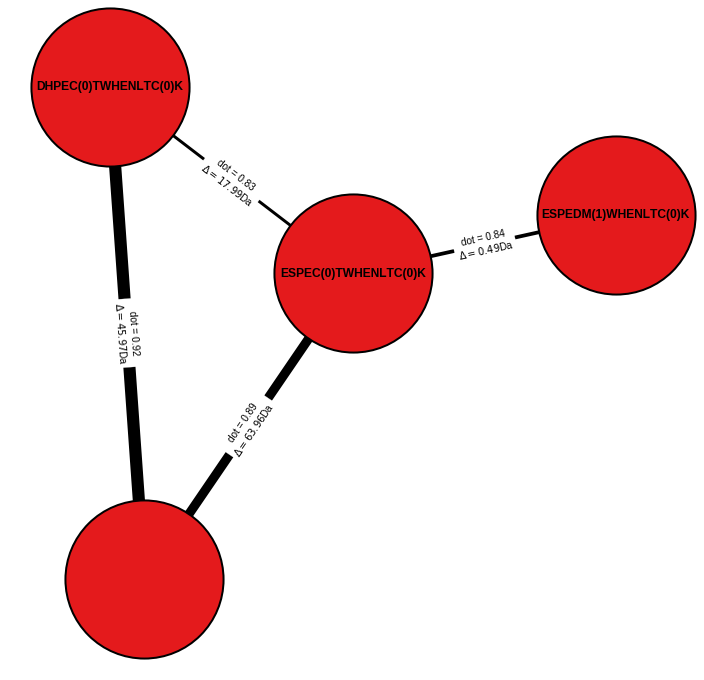

/home/wout/.conda/envs/ypic_challenge_2018/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


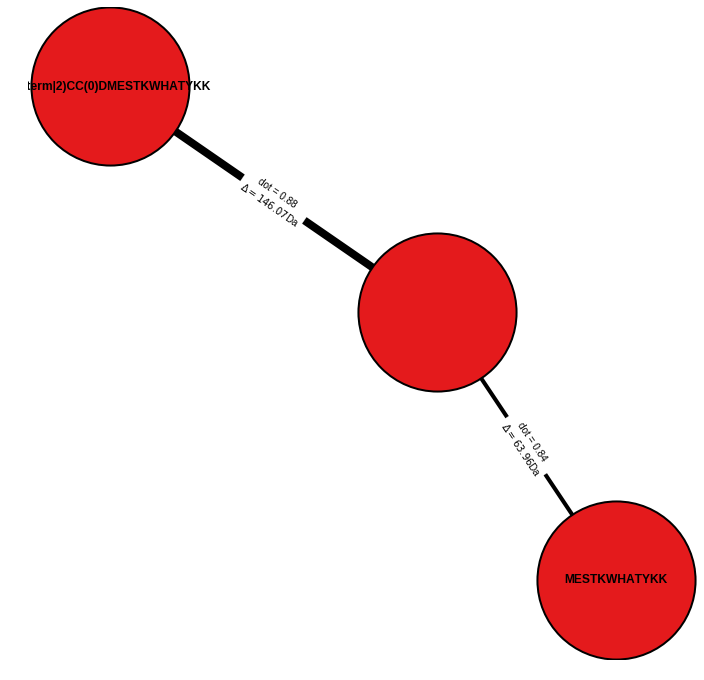

In [22]:
for subgraph in subgraphs:
    for node in subgraph.nodes:
        if node.peptide is not None:
            plot_spectral_network(subgraph)

            # plt.savefig('spectral_network.pdf', dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()
            
            break

In [23]:
mass_diffs = []
for ssm, score in ssm_scores:
    if score >= score_threshold:
        ssm_spectra = [spectra_filtered[i] for i in ssm]
        ion_mass1 = (ssm_spectra[0].precursor_mz - 1.0072766) * ssm_spectra[0].precursor_charge
        ion_mass2 = (ssm_spectra[1].precursor_mz - 1.0072766) * ssm_spectra[1].precursor_charge
        mass_diffs.append(round(abs(ion_mass1 - ion_mass2), 2))

In [24]:
mass_diffs_unique, mass_diffs_counts = np.unique(mass_diffs, return_counts=True)

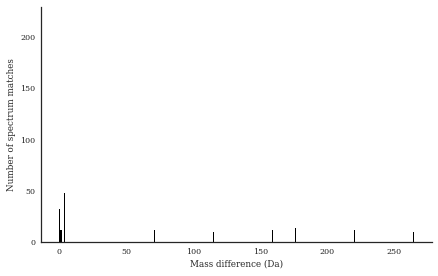

In [25]:
width = 7
height = width / 1.618
fig, ax = plt.subplots(figsize=(width, height))

mask = np.where(mass_diffs_counts >= 10)
ax.bar(mass_diffs_unique[mask], mass_diffs_counts[mask], width=0.4, log=False, color='black')

ax.set_xlabel('Mass difference (Da)')
ax.set_ylabel('Number of spectrum matches')

sns.despine(ax=ax)

# plt.savefig('mass_diff.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [26]:
mass_diffs_df = pd.DataFrame({'Mass difference (Da)': mass_diffs_unique,
                              'Count': mass_diffs_counts})
mass_diffs_df.sort_values('Count', ascending=False).head(10)

,Mass difference (Da),Count
0,0.00,218
20,3.99,48
8,0.88,42
21,4.00,34
4,0.43,32
44,88.05,26
34,44.03,26
50,132.08,20
14,1.57,18
30,27.00,14
